# Chap.5 Blending & Stacking

## 5.1 Abstract

集成学习本质上是把弱学习器(成功率可能仅比随机分类器略好)集合成强学习器的学习方法。不同于Chapter.3 & Chapter.4的Bagging和Boosting，Stacking不需要太多的理论而是一种方法论。Stacking利用第一层的多个基础学习器把预测的结果作为Feature(元特征)输入给第二层的学习器去分类。

介绍Stacking之前需要从Blending入手，因为两者的概念基本类似，而Blending的学习过程更加直接。

## 5.2 Blending

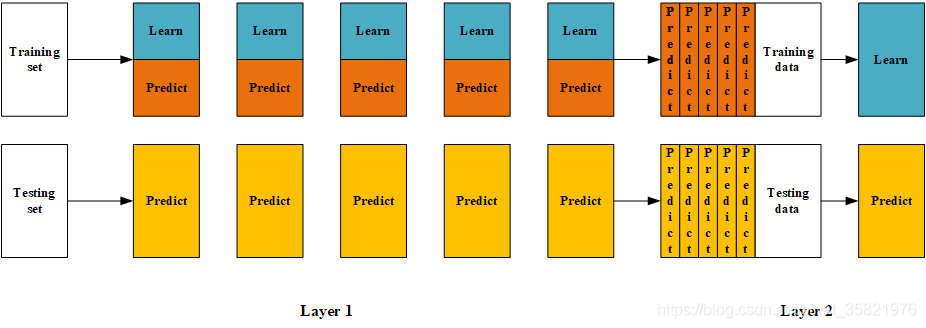

**学习流程：**

    1.源数据集分成训练数据集(Train dataset)和测试数据集(test set),然后把测试数据集再分成训练集(train set)和验证集(validation set).
    For example, 10000条数据分成:
                1) train set(vol=80%*70%*10000=5600);
                2) test set(vol=20%*10000=2000);
                3) validation set (vol=80%*30%*10000=2400);

    2. 创建第一层的模型，这些模型可以是同质的也可以是异质的。
    3. 使用train set 训练第一层的模型;
      然后利用第一层的模型去分别预测test set&validation set;
      之后把两个data set预测出的结果作为feature (test feature & validation feature);
    4. 创建第二层的模型，模型通常是逻辑回归。
    5. 使用 validation feature & validation label 去训练第二层的模型；
      然后把test feature“喂给”训练好的第二层模型去得到test prediction。

这个模型对于数据的利用是“暴殄天物”的方式，但是使用简单粗暴效果往往好挺好。

**以下为Blending的例子：**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [2]:
# 创建数据
from sklearn import datasets 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
data, target = make_blobs(n_samples=10000, centers=2, random_state=1, cluster_std=1.0 )
## 创建Train datset & test set
X_train1,X_test,y_train1,y_test = train_test_split(data, target, test_size=0.2, random_state=1)
## 创建train set & validation set
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=1)
print("The shape of training X:",X_train.shape)
print("The shape of training y:",y_train.shape)
print("The shape of test X:",X_test.shape)
print("The shape of test y:",y_test.shape)
print("The shape of validation X:",X_val.shape)
print("The shape of validation y:",y_val.shape)

The shape of training X: (5600, 2)
The shape of training y: (5600,)
The shape of test X: (2000, 2)
The shape of test y: (2000,)
The shape of validation X: (2400, 2)
The shape of validation y: (2400,)


第一层的学习器为：1)支持向量机; 2)随机森林分类器; 3)KNN分类器

第二层的学习器为：线性回归

In [3]:
#  设置第一层分类器
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = [SVC(probability = True),RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),KNeighborsClassifier()]

# 设置第二层分类器
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [4]:
# 输出第一层的验证集结果与测试集结果
val_features = np.zeros((X_val.shape[0],len(clfs)))  # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs)))  # 初始化测试集结果

for i,clf in enumerate(clfs):
    clf.fit(X_train,y_train)
    val_feature = clf.predict_proba(X_val)[:, 1]
    test_feature = clf.predict_proba(X_test)[:,1]
    val_features[:,i] = val_feature
    test_features[:,i] = test_feature

In [5]:
# 将第一层的验证集的结果输入第二层训练第二层分类器
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([1., 1., 1., 1., 1.])

作业之后再做

## 5.3 Stacking

相比较Blending，Stacking利用交叉验证的方法更加有效地利用数据

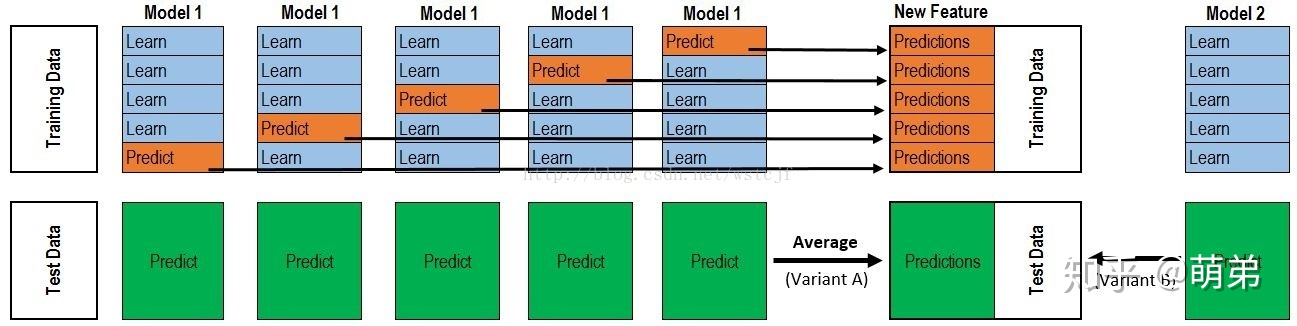

**学习过程：**

    1. 首先将数据分为 train set & test set (for example, train set:10000; test set:2500);
    2. 利用交叉验证的方法，第一层相同的模型会分别利用8000条数据训练，然后预测出另外2000条val set数据的features;
    3. 把第一层模型预测出的的val set的features汇总成10000Xlabel_count的矩阵VAL_1；
       这等于有效地利用了所有的train set;
    4. 利用训练好的第一层模型预测test set的feature,并为每个相同数据不同的预测结果求取加权平均数；
       最后得到一个2500Xlabel_count的矩阵TEST_1；
    5. 利用不同的基模型(比如说3个)分别进行第3&4步的操作,最后得到VAL_1,VAL_2,VAL_3,TEST_1,TEST_2,TEST_3一共6个矩阵；
    6. VAL_1,VAL_2,VAL_3合并成VAL；TEST_1,TEST_2,TEST_3合并成TEST；
    7. 利用VAL去训练下层的分类学习器(比如说逻辑回归),然后得到TEST的prediction；

以下为Stacking的参考案例

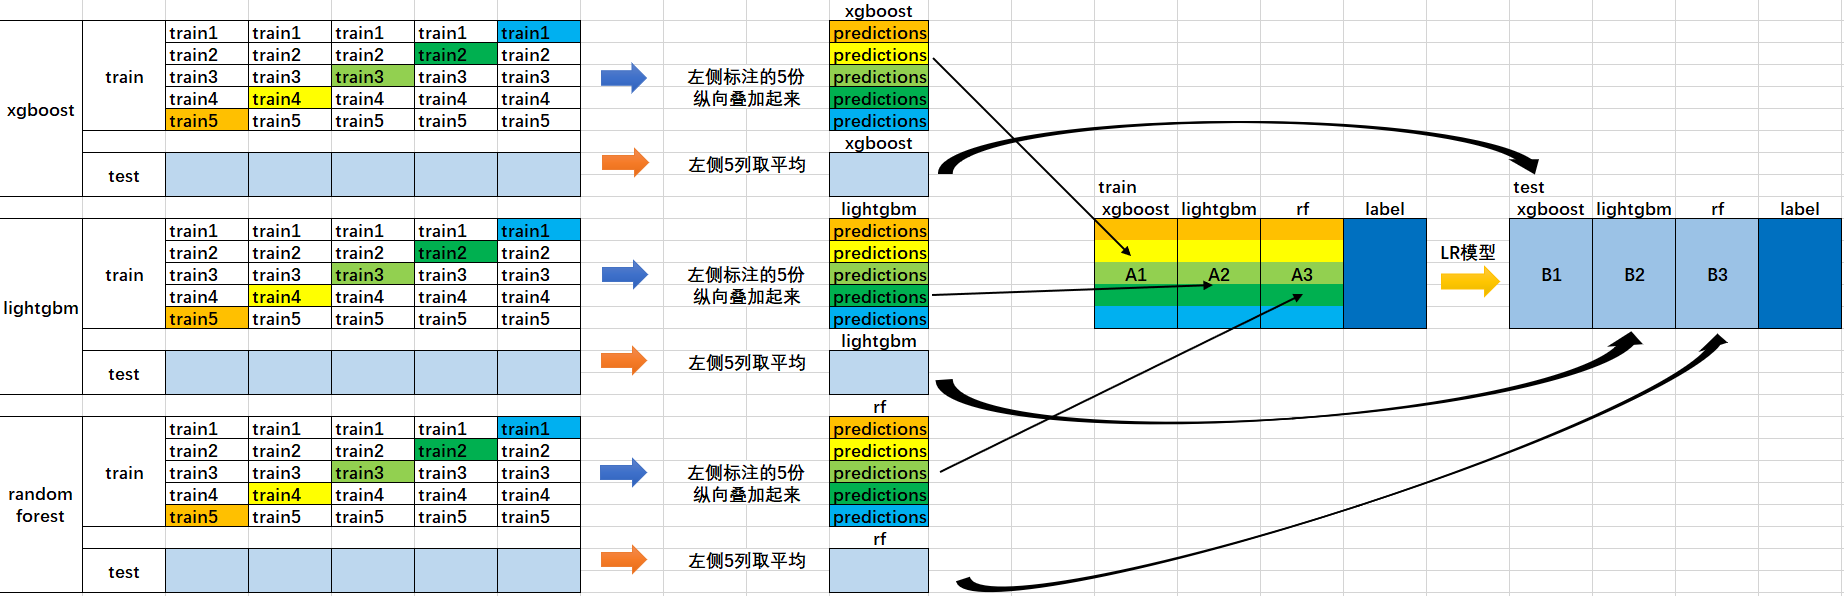

In [10]:
# 1. 简单堆叠3折CV分类
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 66

clf1 = KNeighborsClassifier(n_neighbors=10)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.95 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.01) [StackingClassifier]


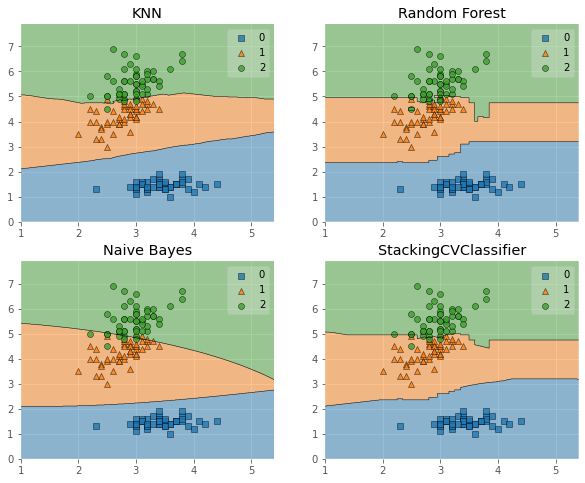

In [11]:
# 我们画出决策边界
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

使用第一层所有基分类器所产生的类别概率值作为meta-classfier的输入。需要在StackingClassifier 中增加一个参数设置：use_probas = True。

另外，还有一个参数设置average_probas = True,那么这些基分类器所产出的概率值将按照列被平均，否则会拼接。

例如：

基分类器1：predictions=[0.2,0.2,0.7]

基分类器2：predictions=[0.4,0.3,0.8]

基分类器3：predictions=[0.1,0.4,0.6]

1）若use_probas = True，average_probas = True，

则产生的meta-feature 为：[0.233, 0.3, 0.7]

2）若use_probas = True，average_probas = False，

则产生的meta-feature 为：[0.2,0.2,0.7,0.4,0.3,0.8,0.1,0.4,0.6]

In [13]:
# 2.使用概率作为元特征
clf1 = KNeighborsClassifier(n_neighbors=10)
clf2 = RandomForestClassifier(random_state=66)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,  # 
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.95 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.01) [StackingClassifier]


In [14]:
# 3. 堆叠5折CV分类与网格搜索(结合网格搜索调参优化)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1,10],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 10, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 10, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 10, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 10, 'meta_classifier__C': 10.0, 'randomforestclassif

In [15]:
# 如果我们打算多次使用回归算法，我们要做的就是在参数网格中添加一个附加的数字后缀，如下所示：
from sklearn.model_selection import GridSearchCV

# Initializing models
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.960 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestcla

In [16]:
# 4.在不同特征子集上运行的分类器的堆叠
##不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn Pipeline和ColumnSelector：
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X, y)

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

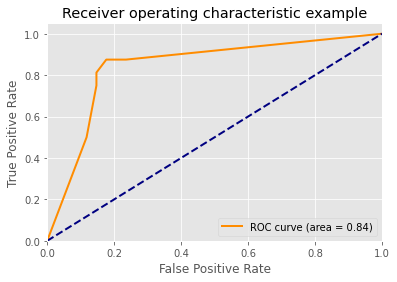

In [17]:
# 5.ROC曲线 decision_function
### 像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。
### 请注意，decision_function期望并要求元分类器实现decision_function。
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Blending与Stacking对比：**

    1.Blending的优点在于比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）
    2.而缺点在于使用了很少的数据可能会过拟合（其实大概率是第一点导致的）